In [1]:
import torch
import torch.nn as nn
from networks.RotCAtt_TransUNet_plusplus_gradcam import RotCAtt_TransUNet_plusplus_GradCam
import SimpleITK as sitk
import numpy as np
import cv2
import matplotlib.pyplot as plt

from networks.dense_feature_extraction import Dense
from networks.linear_embedding import LinearEmbedding
from networks.transformer import Transformer
from networks.rotatory_attention import RotatoryAttention
from networks.recon import Reconstruction
from networks.uct_decoder import UCTDecoder
from networks.config import get_config

In [2]:
class RotModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model_path = 'outputs/RotCAtt_TransUNet_plusplus/VHSCDD_RotCAtt_TransUNet_plusplus_bs6_ps16_epo600_hw512_ly4/model.pth'
        self.trained_model = torch.load(self.model_path)
        self.config = get_config() 
        self.dense = Dense(self.config).cuda()
        self.linear_embedding = LinearEmbedding(self.config).cuda()
        self.transformer = Transformer(self.config).cuda()
        self.rotatory_attention = RotatoryAttention(self.config).cuda()
        self.reconstruct = Reconstruction(self.config).cuda()
        self.decoder = UCTDecoder(self.config).cuda()
        self.out = nn.Conv2d(self.config.df[0], self.config.num_classes, kernel_size=(1,1), stride=(1,1)).cuda()

        # define state dict
        dense_state_dict = self.dense.state_dict()
        embedding_state_dict = self.linear_embedding.state_dict()
        transformer_state_dict = self.transformer.state_dict()
        rot_state_dict = self.rotatory_attention.state_dict()
        recon_state_dict = self.reconstruct.state_dict()
        decoder_state_dict = self.decoder.state_dict()
        out_state_dict = self.out.state_dict()  

        for name, param in self.trained_model.state_dict().items():
            if name.startswith('dense'):
                dense_state_dict[name[len("dense."):]].copy_(param)
            elif name.startswith('linear_embedding'):
                embedding_state_dict[name[len("linear_embedding."):]].copy_(param)
            elif name.startswith('transformer'):
                transformer_state_dict[name[len('transformer.'):]].copy_(param)
            elif name.startswith('rotatory_attention'):
                rot_state_dict[name[len('rotatory_attention.'):]].copy_(param)
            elif name.startswith('reconstruct'):
                recon_state_dict[name[len('reconstruct.'):]].copy_(param)
            elif name.startswith('decoder'):
                decoder_state_dict[name[len('decoder.'):]].copy_(param)
            elif name.startswith('out'):
                out_state_dict[name[len('out.'):]].copy_(param)

        self.dense.eval()
        self.linear_embedding.eval()
        self.transformer.eval()
        self.rotatory_attention.eval()
        self.rotatory_attention.eval()
        self.reconstruct.eval()
        self.decoder.eval()
        self.out.eval()
        self.gradients = []
        
    def activations_hook(self, grad):
        self.gradients.append(grad)

    def get_activations_gradient(self):
        return self.gradients

    def clear_activations_gradient(self):
        self.gradients.clear() 
        
    def get_activations(self, x):
        x1, x2, x3, x4 = self.dense(x)
        z1, z2, z3 = self.linear_embedding(x1, x2, x3)
        e1, e2, e3, a1_weights, a2_weights, a3_weights = self.transformer(z1, z2, z3)
        r1, r2, r3 = self.rotatory_attention(z1, z2, z3)

        f1 = e1 + r1
        f2 = e2 + r2
        f3 = e3 + r3

        o1, o2, o3 = self.reconstruct(f1, f2, f3)
        y = self.decoder(o1, o2, o3, x4)
        y.register_hook(self.activations_hook)
        return self.out(y), y

In [5]:
image_path = 'data/VHSCDD_512/test_images/0001.nii.gz'
model = RotModel()

num_slice      = 4
class_instance = 6
index_list     = [397, 399, 396,  395]
instance_list  = [7, 11, 11, 11]

In [6]:
assert len(index_list) == len(instance_list), print(
        "Length of list of indices is not equal to length of list of instances")
    
name_dict = {
    0: "background",
    1: "left_ventricle",
    2: "right_ventricle",
    3: "left_atrium",
    4: "right_atrium",
    5:  "myocardium",
    6: "descending_aeorta",
    7: "pulmonary_trunk",
    8: "ascending_aorta",
    9: "vena_cava",
    10: "auricle",
    11: "coronary_artery",
}

num_slice = len(index_list)
image = sitk.GetArrayFromImage(sitk.ReadImage(image_path, sitk.sitkFloat32))

output = np.ones((num_slice, 512, 512), dtype=np.float32)
slice_list = np.array([image[index] for index in index_list])

for i in range(num_slice): output[i,:,:] = slice_list[i]

input = torch.from_numpy(output).unsqueeze(1).cuda()
output, activations = model.get_activations(input)
activations = activations.detach()

In [ ]:
colormap = cv2.COLORMAP_JET
fig, axes = plt.subplots(nrows=2, ncols=num_slice, figsize=(16,16))

In [8]:
x = 0
class_output = output[x, instance_list[x]]
class_score_sum = class_output.sum()
class_score_sum.backward(retain_graph=True)

class_output = output[x, class_instance]
class_score_sum = class_output.sum()
class_score_sum.backward(retain_graph=True)


gradients = model.get_activations_gradient()
print(f"Length gradients: {len(gradients)}")
gradients = gradients[-1]
model.clear_activations_gradient()
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

print(f"Pooled Gradient: {pooled_gradients.shape}")

instance_activation = activations[x]

for channel in range(64):
    instance_activation[channel, :, :] *= pooled_gradients[channel]

print(f"Activations: {instance_activation.shape}")

heatmap = torch.mean(instance_activation, dim=0)
print(f"Heatmap shape: {heatmap.shape}")

heatmap /= torch.max(heatmap)
heatmap = heatmap.cpu().numpy()
heatmap = np.maximum(heatmap, 0)

heatmap = cv2.resize(heatmap, (512,512))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, colormap)

image0 = torch.squeeze(input[x, :, :, :])
image0 = image0.cpu().numpy()
image0 = cv2.cvtColor(image0, cv2.COLOR_GRAY2BGR)

superimposed_img = (heatmap / 255.0) * 0.6 + image0

Length gradients: 2
Pooled Gradient: torch.Size([64])
Activations: torch.Size([64, 512, 512])
Heatmap shape: torch.Size([512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


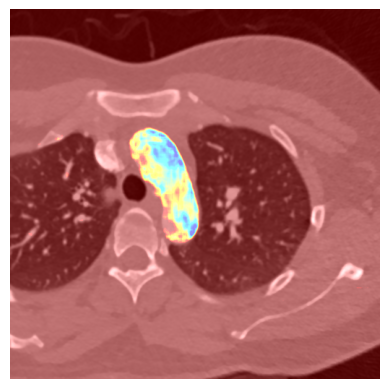

In [9]:
plt.axis('off')
plt.imshow(superimposed_img)

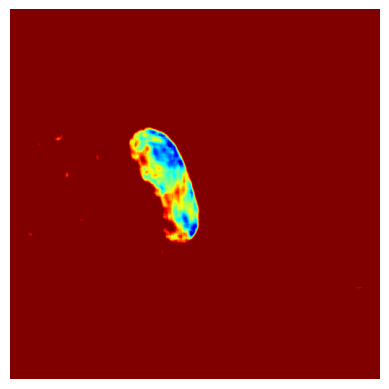

In [10]:
plt.axis('off')
plt.imshow(heatmap)